### Import

In [1]:
# Libraries
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
from IPython.display import HTML

# Files
from vehicle import *
from plotting import *
from simulate import *
from mpc import *
from global_path_planning import *
 

### Simulation Input Parameters

In [2]:
# #### MPC Properties
# dt = 1                  # Time step [s]
# N = 25                  # Time Horizon

# ####  Simulation/Problem Parameters
# pos_constraints = [0, 50, 0, 50]         # Position Constraints [m]:    [x_min, x_max, y_min, y_max]
# x_init = np.array([0, 0, 0, 0])          # Initial State: [x, y, x_dot, y_dot]
# x_target_last = np.array([50, 50, 0, 0])      # Target State: [x, y, x_dot, y_dot]
# T = 150                                   # Simulation time [s]

# # Obstacle Definition: list[] obstacle = [center_x, center_y, radius]
# obstacles = [[20, 40, 2], [10, 10, 2], [30, 20, 10], [10, 20, 5], [18, 30, 4], [20, 5, 3], [8, 35, 3]]
# waypoint_radius = 5

# # Moving Obstacle Definition: list[] moving_obstacle = [center_x, center_y, vel_x, vel_y, radius]  
# move_obstacles = [[30, 50, 0, -1, 5], [50, 40, -0.3, 0, 5]]

# #### Drone Velocity & Acceleration Constraints
# vel_constraints = [-1, 1, -1, 1]         # Velocity Constraints [m/s]:  [x_min, x_max, y_min, y_max] 
# acc_constraints = [-10, 10, -10, 10]         # Acceleration Constraints [m/s^2]:    [x_min, x_max, y_min, y_max] 

In [3]:
#### MPC Properties
dt = 1                  # Time step [s]
N = 10                  # Time Horizon

####  Simulation/Problem Parameters
pos_constraints = [0, 20, 0, 50]         # Position Constraints [m]:    [x_min, x_max, y_min, y_max]
x_init = [10, 2, 0, 0]          # Initial State: [x, y, x_dot, y_dot]
x_target_last = [10, 48, 0, 0]      # Target State: [x, y, x_dot, y_dot]
T = 150                                   # Simulation time [s]

# Obstacle Definition: list[] obstacle = [center_x, center_y, radius]
obstacles = [[10, 20, 4], [18, 30, 3], [7, 40, 5]]
waypoint_radius = 5

# Moving Obstacle Definition: list[] moving_obstacle = [center_x, center_y, vel_x, vel_y, radius]  
move_obstacles = [[20, 40, -0.7, 0, 5], [17, 0, 0, 1, 5], [20, 10, -1, 0, 4]]

#### Drone Velocity & Acceleration Constraints
vel_constraints = [-1, 1, -1, 1]         # Velocity Constraints [m/s]:  [x_min, x_max, y_min, y_max] 
acc_constraints = [-10, 10, -10, 10]         # Acceleration Constraints [m/s^2]:    [x_min, x_max, y_min, y_max]

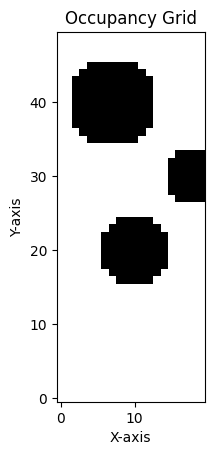

RRT*


IntProgress(value=0, max=3000)

Goal found


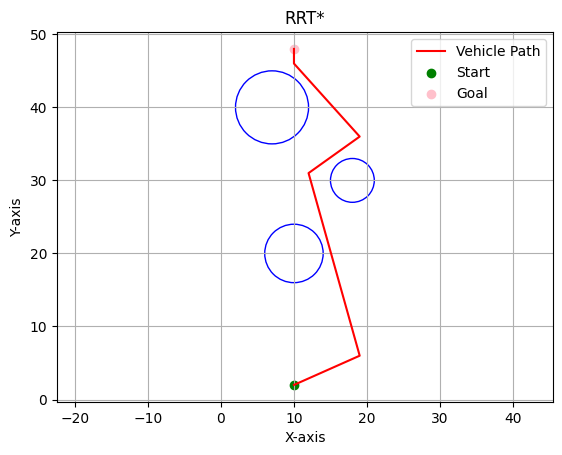

In [4]:
# Run RRT*
#get global a_star path and visualize
occupancy_grid = OccupancyGrid(1, [pos_constraints[0], pos_constraints[2]], obstacles, [pos_constraints[1], pos_constraints[3]], obstacle_margin=.4)
occupancy_grid.plot()

start = x_init[:2]
goal = x_target_last[:2]

print("RRT*")
path_rrt = rrt_star(occupancy_grid, start, goal, radius=30, max_iter=3000)

path_rrt.plot()


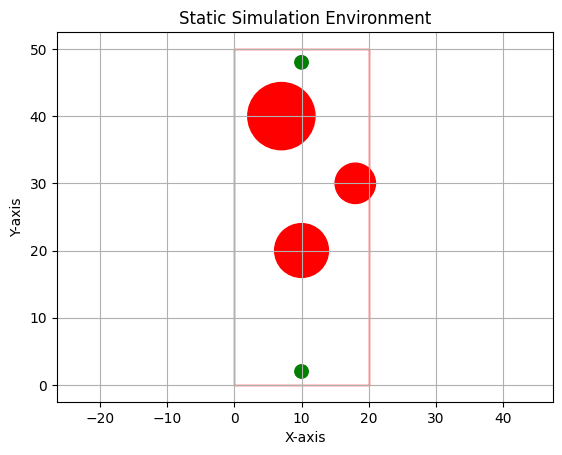

In [5]:
# Plot the static Obstacles
plot_static_obstacles(obstacles, pos_constraints, x_init, x_target_last)

In [6]:
# Setup vehichle & controller then Simulate
vehicle = vehicle_SS(dt)
controller = lambda x_init, current_wp, move_obstacles : mpc_control(vehicle, N, x_init, current_wp, pos_constraints, vel_constraints, acc_constraints, obstacles, move_obstacles)
states, inputs, plans, timesteps, target_state = simulate(dt, T, x_init, N, controller, move_obstacles, path_rrt, waypoint_radius, num_states=len(x_init), num_inputs=2)

Timesteps: 150


 CURRENT TARGET: [19, 6, 0, 0] 



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0) 550.00us ( 26.19us)        21
       nlp_g  |        0 (       0) 492.00us ( 23.43us)        21
  nlp_grad_f  |        0 (       0)   1.28ms ( 58.05us)        22
  nlp_hess_l  |        0 (       0)   3.17ms (158.50us)        20
   nlp_jac_g  |  21.00ms (954.55us)   1.95ms ( 88.77us)        22
       total  |  54.00ms ( 54.00ms)  51.55ms ( 51.55ms)         1
Optimal cost: 2643.060481082594


 CURRENT TARGET: [19, 6, 0, 0] 


      solver  :   t_proc      (a

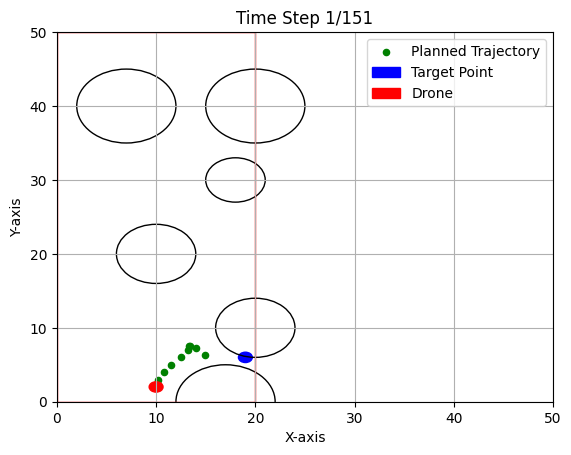

In [7]:
def update(frame):
    # Clear previous frame
    plt.cla()

    move_obstacles_update = MovingObstacleConvert(move_obstacles, frame, dt)
    
    # Plot Path for current state
    plt.scatter(plans[0][:, frame], plans[1][:, frame], c='g', s=20, label = "Planned Trajectory")

    # Plot current state
    drone = plt.Circle((target_state[0][frame], target_state[1][frame]), 0.7, color='b', fill=True, label = "Target Point")
    plt.gca().add_patch(drone)

    drone = plt.Circle((states[0][frame], states[1][frame]), 0.7, color='r', fill=True, label = "Drone")
    plt.gca().add_patch(drone)
    
    for obstacle in obstacles:
        circle = plt.Circle((obstacle[0], obstacle[1]), obstacle[2], color='k', fill=False)
        plt.gca().add_patch(circle) 

    for obstacle in move_obstacles_update:
        circle = plt.Circle((obstacle[0], obstacle[1]), obstacle[2], color='k', fill=False)
        plt.gca().add_patch(circle) 

    # Env Boundaries
    x = pos_constraints[0]
    y = pos_constraints[2]
    width = pos_constraints[1]-x
    height = pos_constraints[3]-x
    rectangle = patches.Rectangle((x, y), width, height, edgecolor='red', facecolor='none')
    plt.gca().add_patch(rectangle)

    plt.legend()
    plt.title(f'Time Step {frame + 1}/{len(states[1])}')  # Set title for each frame
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.xlim(0, 50)
    plt.ylim(0, 50)
    plt.grid()

# Create the animation
fig = plt.figure()
ani = FuncAnimation(fig, update, frames=len(states[1]), interval=100)

# Display the animation within the Jupyter Notebook using HTML
HTML(ani.to_jshtml())
